# End-To-End Training Example of RNN for rain estimation and detection using PyNNCML
This notebook presents an end-to-end example of training a Recurrent Neural Network (RNN) based rain estimation neural network [1] on the openMRG dataset[2].
This tutorial is built using the PyNNCML software package, which provides both tools to simplify the training process of deep learning models for CMLs.
We start with obtaining a subset of the OpenMRG dataset and splitting it into training and validation datasets.
Afterward, we construct the One Step Network from [1], followed by the training loop.
Finally, we analyze the model performance in terms of RMSE and Bias.


Notebook structure
1. Imports and Installation of PyNNCML
2. Hyperparameter settings
3. Build Dataset
4. Build Neural Network
5. Training Loop
6. Neural Network Analysis


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/main/examples/tutorials/data_driven_tutorial.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [1]:
%load_ext autoreload

In [2]:
import sys
import os


In [3]:
!pip install utm

In [4]:
def is_colab():
    return 'google.colab' in sys.modules

def is_local_windows():
    return os.name == 'nt' and not is_colab()

# Example usage
if is_colab():
    print("Running on Google Colab")
elif is_local_windows():
    print("Running locally on Windows")
else:
    print("Running elsewhere")



if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')

    # base_path = '/content/drive/Othercomputers/המחשב האישי שלי/סמסטר ב 2025/תקשורת וחישה משולבות לשערוך מזג אוויר/מטלה 3/code/PyNNcml'
    base_path = '/content/drive/Othercomputers/המחשב האישי שלי/code/PyNNcml'

    if base_path not in sys.path:
        sys.path.insert(0, base_path)

else:
    if os.path.exists('../../pynncml'):
        print("Import PyNNCML From Local Code")
        sys.path.insert(0, '../../')

Running on Google Colab
Mounted at /content/drive


In [5]:
import pickle

# if os.path.exists('../../pynncml'):
#     print("Import PyNNCML From Code")
#     # sys.path.append('../../')  # This line is need to import pynncml
#     sys.path.insert(0, '../../')
# else:
#     print("Install PyNNCML From pip")
#     !pip install pynncml

import numpy as np
import pynncml as pnc
import torch
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy
from sklearn import metrics


In [6]:
print(pnc.__file__)

/content/drive/Othercomputers/המחשב האישי שלי/code/PyNNcml/pynncml/__init__.py


# Hyper-Parameters

In [7]:
results_path = "results_files"
use_pretrained = False
experiment_name = "exp_31"
model_path = f"{results_path}/pretrained_model_exp_4.pth" if use_pretrained else f"{results_path}/pretrained_model_{experiment_name}.pth"

# if condition init dataset, else read from pickle
to_load_dataset = True


#  @title Hyper-parameters
batch_size = 16  # @param{type:"integer"}
window_size = 32  # @param{type:"integer"}
rnn_n_features = 128  # @param{type:"integer"}
rnn_input_size = 180
metadata_n_features = 32  # @param{type:"integer"}
metadata_n_hidden = 1
n_layers = 2  # @param{type:"integer"}
lr = 1e-4  # @param{type:"number"}
weight_decay = 1e-4  # @param{type:"number"}
rnn_type = pnc.neural_networks.RNNType.GRU  # RNN Type
n_epochs = 400  # @param{type:"integer"} # number of pretrain epochs
transfer_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


to_abs_metadata = False
torch.manual_seed(42)



cuda:0


In [8]:
# xy0, xy1 = obj.meta_data.xy_zero, obj.meta_data.xy_one
# xy_gauge = (obj.gauge_ref.x, obj.gauge_ref.y)
# xy_gauge = np.array([xy_gauge[0][0], xy_gauge[1][0]])
# print(f"{xy0 = },\n {xy1 = },\n {xy_gauge = }")

# xy_link = np.stack([xy0, xy1]).mean(axis=0)
# print(f"{xy_link = }")


# Building Training and Validation datasets

In [9]:
xy_min = [1.29e6, 0.565e6]  # Link Region
xy_max = [1.34e6, 0.5875e6]
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
# dataset = pnc.datasets.loader_open_mrg_dataset(data_path=".\\data\\", xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)

In [10]:
import os

# Assuming the notebook is in a directory structure where the root of the project
# is above the directory containing the notebook.
# Get the current notebook path
# This only works in Colab environments where __file__ is defined,
# which is not the case in standard Jupyter notebooks.
# In standard Jupyter/Colab, you can often rely on the fact that the working directory
# is the directory the notebook is in by default, or change it explicitly.

# Let's try to find the notebook's directory and change the working directory to it.
# This is a heuristic and might not work in all environments.
try:
    # In Colab, __file__ is often not set, and the working directory is the notebook's directory.
    # If it's not, we can try to infer it from the base_path we defined earlier if running in Colab.
    if is_colab():
        notebook_dir = os.path.dirname(base_path + '/examples/tutorials/data_driven_tutorial.ipynb')
        if os.path.exists(notebook_dir):
             print(f"Changing directory to {notebook_dir}")
             os.chdir(notebook_dir)
        else:
            print(f"Could not find notebook directory based on base_path: {notebook_dir}")
            print("Current working directory:", os.getcwd())
    else:
         # In other environments, the working directory is often the notebook's directory by default.
         # If not, we can try to get the path of the currently executing script (which is this notebook).
         # However, getting the path of a running notebook reliably is tricky.
         # A common workaround is to explicitly set the directory.
         print("Assuming working directory is the notebook's directory or manually set.")
         print("Current working directory:", os.getcwd())

except NameError:
    print("Could not automatically determine notebook directory.")
    print("Current working directory:", os.getcwd())

print("Current working directory after change attempt:", os.getcwd())

Changing directory to /content/drive/Othercomputers/המחשב האישי שלי/code/PyNNcml/examples/tutorials
Current working directory after change attempt: /content/drive/Othercomputers/המחשב האישי שלי/code/PyNNcml/examples/tutorials


In [11]:
# Check if pickle file exists
pickle_path = "dataset.pkl"
if to_load_dataset==False:
    # Initialize dataset from loader
    print("Initializing dataset from loader...")
    dataset = pnc.datasets.loader_open_mrg_dataset(data_path=".\\data\\", xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)

    # Save dataset to pickle
    with open(pickle_path, 'wb') as f:
        pickle.dump(dataset, f)
    print(f"Dataset saved to {pickle_path}")
elif to_load_dataset:
    # Load dataset from pickle
    print(f"Loading dataset from {pickle_path}...")
    with open(pickle_path, 'rb') as f:
        dataset = pickle.load(f)
    print("Dataset loaded successfully")


Loading dataset from dataset.pkl...
Dataset loaded successfully


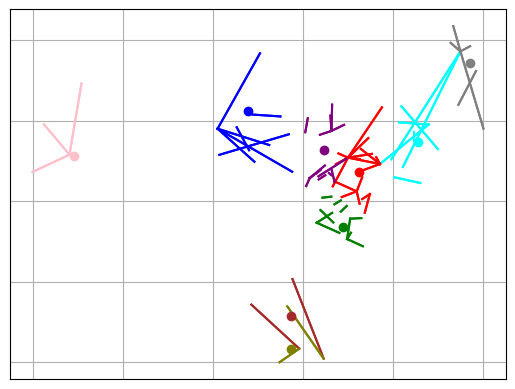

In [12]:
dataset.link_set.plot_links(scale=True, scale_factor=1.0)
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

In [13]:
rain, rsl, tsl, metadata = dataset[0]

In [14]:
print(f"{rain.shape=}")
print(f"{rsl.shape=}")
print(f"{tsl.shape=}")
print(f"{metadata.shape=}")
print(f"{metadata=}")
# print(f"{metadata['site_0_lat']=}")
# print(f"{metadata['site_0_lon']=}")
# print(f"{metadata['site_1_lat']=}")
# print(f"{metadata['site_1_lon']=}")
# print(f"{metadata['frequency']=}")

rain.shape=(958,)
rsl.shape=(958, 90)
tsl.shape=(958, 90)
metadata.shape=(7,)
metadata=array([38.584     ,  1.18227   ,  0.92187154,  0.48224425, -0.8760368 ,
        0.44456726, -0.8075934 ], dtype=float32)


In [15]:
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader = torch.utils.data.DataLoader(training_dataset, batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size)

# Compute rain rate statistics
In this section, we compute the rain rate statistics of the dataset. The rain rate statistics are used to understand the distribution of the rain rate in the dataset.
In addition we estimate the parameters of the exponential distribution that fits the rain rate data that will be utilized in later stage to compute a balanced loss function.


Rain Rate Statistics
Mean[mm/hr]: 0.12803642582835345
Std[mm/hr]: 0.6123836062324627
Parentage of wet samples 10.171653908605892
Parentage of dry samples 89.82834609139411
Exponential Distribution Parameters: (0.0, 0.12803642582835345)


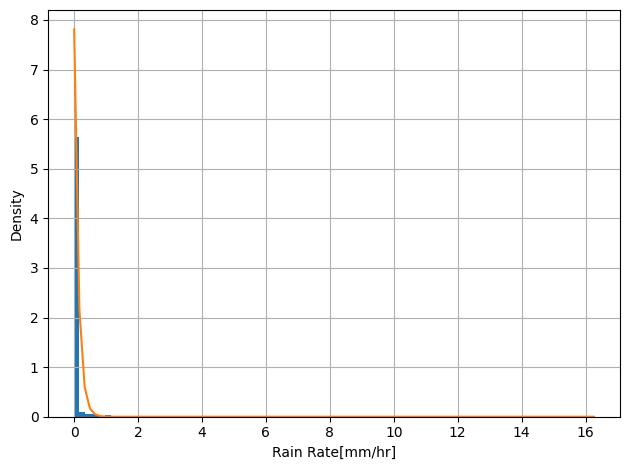

In [16]:
rg = np.stack([p.data_array for p in dataset.point_set]).flatten()
param = scipy.stats.expon.fit(rg)
exp_gamma = param[1]
print("Rain Rate Statistics")
print("Mean[mm/hr]:", np.mean(rg))
print("Std[mm/hr]:", np.std(rg))
print("Parentage of wet samples", 100 * np.sum(rg > 0) / rg.size)
print("Parentage of dry samples", 100 * np.sum(rg == 0) / rg.size)
print("Exponential Distribution Parameters:", param)
_ = plt.hist(rg, bins=100, density=True)
plt.plot(np.linspace(0, np.max(rg), 100), scipy.stats.expon.pdf(np.linspace(0, np.max(rg), 100), *param))
plt.grid()
plt.xlabel("Rain Rate[mm/hr]")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


# Neural Network

The neural network is constructed using the PyTorch library. The network consists of two main components: <br>
1. RNN: A recurrent neural network that takes the CML signal and the metadata as input and outputs the rain rate. <br>
2. Metadata: A fully connected layer that takes the metadata as input and outputs a feature vector. <br>
The RNN is trained to predict the rain rate at each time step based on the CML signal and the metadata. <br>
3. The network architecture is shown in the figure below: <br>
![Alt text](https://raw.githubusercontent.com//haihabi/PyNNcml/main/images/two_step_network.png )


The network consists of the following components:<br>
1. A backbone that is built of RNN layers that process the CML attenuation and the metadata (shown in blue). <br>
2. A wet/dry classifier that is built of fully connected layers that process backbone feature and produce wet/dry prediction (shown in red). <br>
3. A rain rate estimator that is built of fully connected layers that process backbone feature and produce rain rate prediction (shown in green). <br>






In [17]:
metadata_input_size = len(dataset[0][-1])
metadata_feature_mask = torch.zeros(metadata_input_size, dtype=torch.bool) # original
# metadata_feature_mask = torch.ones(metadata_input_size, dtype=torch.bool)
metadata_feature_mask[:2] = 1 # original
print(metadata_feature_mask)


tensor([ True,  True, False, False, False, False, False])


In [18]:
# base model
model = pnc.scm.rain_estimation.two_step_network(
            n_layers=n_layers,  # Number of RNN layers
            rnn_type=rnn_type,  # Type of RNN (GRU, LSTM)
            normalization_cfg=pnc.training_helpers.compute_data_normalization(data_loader),  # Compute the normalization statistics from the training dataset.
            rnn_input_size=rnn_input_size,  # 180,  # 90 + 90 (RSL + TSL)
            rnn_n_features=rnn_n_features,  # Number of features in the RNN
            metadata_input_size=len(dataset[0][-1]),  # Number of metadata features
            metadata_n_features=metadata_n_features,
            metadata_n_hidden=metadata_n_hidden,  # Number of hidden layers in the metadata block
            # New parameters available in the constructor:
            metadata_feature_mask=metadata_feature_mask,
            freeze_rnn=False,
            model_file_path=model_path,
            pretrained=use_pretrained
        ).to(device)


In [19]:
# Count total parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Count non-trainable parameters
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Non-trainable parameters: {non_trainable_params:,}")

# Detailed breakdown by module
print("\nParameter breakdown by module:")
for name, module in model.named_modules():
    if len(list(module.children())) == 0:  # Only leaf modules
        params = sum(p.numel() for p in module.parameters())
        if params > 0:
            print(f"{name}: {params:,} parameters")


Total number of parameters: 220,120
Trainable parameters: 219,746
Non-trainable parameters: 374

Parameter breakdown by module:
bb.rnn: 218,112 parameters
bb.metadata_block.metadata_block.0: 256 parameters
bb.metadata_block.metadata_block.2: 1,056 parameters
bb.normalization: 374 parameters
rh.fc: 161 parameters
wdh.fc: 161 parameters




The loss function used to train the rain estimation model is as follows:
$$J(\Theta)=J_{\mathrm{BCE}}+\lambda J_{\mathrm{Reg}},$$
where $J_{\mathrm{BCE}}$ is a binary cross entropy loss and
$$J_{\mathrm{Reg}}=\frac{1}{N_b}\sum_{i=1}^{N_b}\sum_{j=1}^{N_s}(1-\gamma_s\exp(-\gamma \cdot r_{i,j}))\cdot(\hat{r}_{i,j}-r_{i,j})^2,$$
is the regression loss function.


In [20]:
class RegressionLoss(torch.nn.Module):
    def __init__(self, in_gamma, gamma_s=0.9):
        super(RegressionLoss, self).__init__()
        self.in_gamma = in_gamma
        self.gamma_s = gamma_s

    def forward(self, input, target):
        delta = (target - input) ** 2
        w = 1 - self.gamma_s * torch.exp(-self.in_gamma * target)
        return torch.sum(torch.mean(w * delta, dim=0))


loss_function_rain_est = RegressionLoss(exp_gamma)
loss_function_wet_dry = torch.nn.BCELoss()

# Find lambda values such that at initialization both loss will be equal:
loss_est = 0
loss_detection = 0
with torch.no_grad():
    for rain_rate, rsl, tsl, metadata in data_loader:
        if to_abs_metadata:
          metadata = torch.abs(metadata)
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_hat = rain_estimation_detection[:, :, 0]
            rain_detection = rain_estimation_detection[:, :, 1]

            loss_est += loss_function_rain_est(rain_hat, _rr)
            loss_detection += loss_function_wet_dry(rain_detection, (_rr > 0.1).float())
lambda_value = loss_detection / loss_est

# Training Loop

The training loop consists of the following steps:
1. Initialize the optimizer and loss function: <br>
    a. Optimizer: We use the RAdam optimizer with a learning rate of 1e-4 and a weight decay of 1e-4. <br>
    b. Loss Function: We use the Mean Squared Error (MSE) loss function to compute the loss. <br>
2. Iterate over the training dataset and compute the loss. <br>
3. Update the model parameters using the optimizer. <br>
4. Compute the average loss over the training dataset.  <br>
5. Repeat the process for a fixed number of epochs.

In [21]:
if not use_pretrained:

    opt = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # ra = pnc.analysis.ResultsAccumulator()
    # am = pnc.analysis.AverageMetric()
    ra = pnc.metrics.ResultsAccumulator()
    am = pnc.metrics.AverageMetric()

    model.train()
    print("Start Training")
    for epoch in tqdm(range(n_epochs)):

        am.clear()
        for rain_rate, rsl, tsl, metadata in data_loader:
            if to_abs_metadata:
                metadata = torch.abs(metadata)
            state = model.init_state(batch_size=rsl.shape[0])
            m_step = math.floor(rain_rate.shape[1] / window_size)
            for step in range(m_step):
                opt.zero_grad()  # Zero gradients
                # Perform sliding window in the CML time series.
                _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
                _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
                _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
                # Forward pass of the model
                rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                        state.detach())
                rain_hat = rain_estimation_detection[:, :, 0]
                rain_detection = rain_estimation_detection[:, :, 1]
                # Compute loss function
                loss_est = loss_function_rain_est(rain_hat, _rr)
                loss_detection = loss_function_wet_dry(rain_detection, (_rr > 0.1).float())
                loss = lambda_value * loss_est + loss_detection
                # Take the derivative w.r.t. model parameters $\Theta$
                loss.backward()
                opt.step()

                am.add_results(loss=loss.item(), loss_est=loss_est.item(),
                            loss_detection=loss_detection.item())  # Log results to average.
        ra.add_results(loss=am.get_results("loss"), loss_est=am.get_results("loss_est"),
                    loss_detection=am.get_results("loss_detection"))
    # save model
    model_path = f"{results_path}/pretrained_model_{experiment_name}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
else:
    ra = pnc.metrics.ResultsAccumulator()
    am = pnc.metrics.AverageMetric()
    print("Not training, using pretrained model from: ", model_path)





Start Training


100%|██████████| 400/400 [07:24<00:00,  1.11s/it]

Model saved to results_files/pretrained_model_exp_31.pth


# Analysis of training progress
Here, we plot loss of the model during optimization.

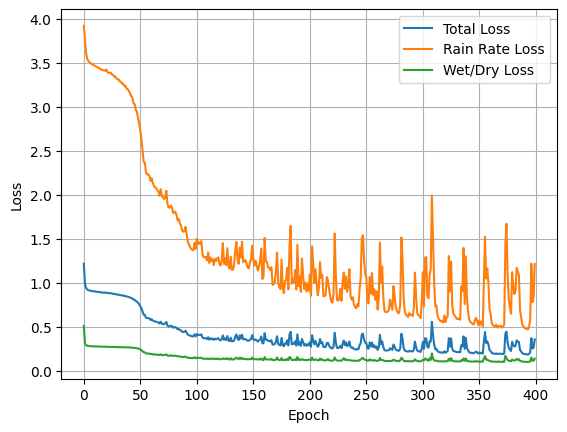

In [22]:
if not use_pretrained:
    plt.plot(ra.get_results("loss"), label="Total Loss")
    plt.plot(ra.get_results("loss_est"), label="Rain Rate Loss")
    plt.plot(ra.get_results("loss_detection"), label="Wet/Dry Loss")
    plt.grid()
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
else:
    print("Model already trained")

# Model Validation
In this section we validate the neural network quality on the validation datasets. First we provide a statistical results of the trained model which include:
1. Estimation Bias
2. Estimation RMSE
3. Accuracy of Detection
4. Confusion Matrix
5. F1 Score


Secondly we provide some visualization to analyze the model performance.



Results Detection:
Validation Results of Two-Step RNN
Accuracy[%]: 96.61637931034483
F1 Score: 0.7727930535455861
Precision: 0.8177641653905053
Recall: 0.7325102880658436


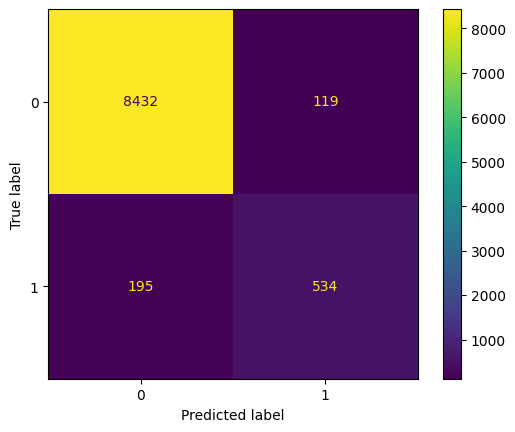

Results Estimation:
-------------------------------------------------- Results Summery --------------------------------------------------
+--------------+-------------------------+----------------------------------------+----------------------------------------+---------------------------------------+---------------------------------------+
|    Metric    | 0.0<r<1.590000033378601 | 1.590000033378601<r<3.1700000762939453 | 3.1700000762939453<r<4.760000228881836 | 4.760000228881836<r<6.349999904632568 | 6.349999904632568<r<7.929999828338623 |
+--------------+-------------------------+----------------------------------------+----------------------------------------+---------------------------------------+---------------------------------------+
|     RMSE     |           0.24          |                  1.05                  |                  1.63                  |                  3.23                 |                  4.43                 |
|     BIAS     |          -0.02          |

In [23]:
model.eval()
# ga = pnc.analysis.GroupAnalysis()
ga = pnc.metrics.GroupAnalysis()
with torch.no_grad():
    for rain_rate, rsl, tsl, metadata in val_loader:
        if to_abs_metadata:
            metadata = torch.abs(metadata)
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        am.clear()
        rain_ref_list = []
        rain_hat_list = []
        detection_list = []

        for step in range(m_step):
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_detection = rain_estimation_detection[:, :, 1]
            rain_hat = rain_estimation_detection[:, :, 0] * torch.round(
                rain_detection)  # Rain Rate is computed only for wet samples
            rain_hat_list.append(rain_hat.detach().cpu().numpy())
            rain_ref_list.append(_rr.detach().cpu().numpy())
            ga.append(rain_ref_list[-1], rain_hat_list[-1])
            detection_list.append(torch.round(rain_detection).detach().cpu().numpy())
            delta = rain_hat.squeeze(dim=-1) - _rr
            bias = torch.mean(delta)
            mse = torch.mean(delta ** 2)
            am.add_results(bias=bias.item(), mse=mse.item())
# actual = np.concatenate(detection_list).flatten()
# predicted = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
predicted = np.concatenate(detection_list).flatten()
actual = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
confusion_matrix = metrics.confusion_matrix(actual, predicted)
max_rain = np.max(np.concatenate(rain_ref_list))
g_array = np.linspace(0, max_rain, 6)

print("Results Detection:")
print("Validation Results of Two-Step RNN")
print("Accuracy[%]:", 100 * (np.sum(actual == predicted) / actual.size))
print("F1 Score:", metrics.f1_score(actual, predicted))
print("Precision:", metrics.precision_score(actual, predicted))
print("Recall:", metrics.recall_score(actual, predicted))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

cm_display.plot()
plt.show()

print("Results Estimation:")
_, _, _, nrmse, nbias = ga.run_analysis(np.stack([g_array[:-1], g_array[1:]], axis=-1))


In [24]:

results_dict = {
    "loss": ra.get_results("loss"),
    "loss_est": ra.get_results("loss_est"),
    "loss_detection": ra.get_results("loss_detection"),
    "accuracy": 100 * (np.sum(actual == predicted) / actual.size),
    "f1_score": metrics.f1_score(actual, predicted),
    "precision": metrics.precision_score(actual, predicted),
    "recall": metrics.recall_score(actual, predicted),
    "confusion_matrix": confusion_matrix,
    "nbias": nbias,
    "nrmse": nrmse
}

if not use_pretrained:
    # save results dict
    with open(f"{results_path}/pretrain_results_{experiment_name}.pkl", "wb") as f:
        pickle.dump(results_dict, f)

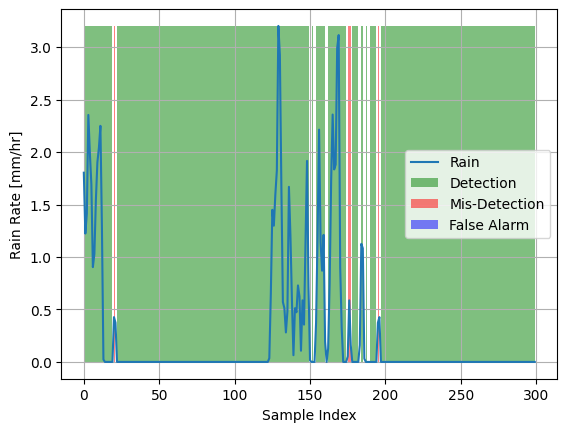

In [25]:
detection_array = np.concatenate(detection_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)
detection_array = np.round(detection_array)

rain_array = rain_ref_array[0, :300]
detection_array = detection_array[0, :300]
fig, ax = plt.subplots()
x = np.arange(rain_array.shape[0])
ax.plot(x, rain_array, label="Rain")
rain_max = np.max(rain_array)
ax.fill_between(x, rain_max, where=np.logical_or(np.logical_and(detection_array == 1, rain_array > 0),
                                                 np.logical_and(detection_array == 0, rain_array == 0)),
                                                 facecolor='green', alpha=.5, label="Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 0, rain_array > 0), facecolor='red',
                alpha=.5, label="Mis-Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 1, rain_array == 0), facecolor='blue',
                alpha=.5, label="False Alarm")
plt.legend()
plt.ylabel("Rain Rate [mm/hr]")
plt.xlabel("Sample Index")
plt.grid()
plt.show()

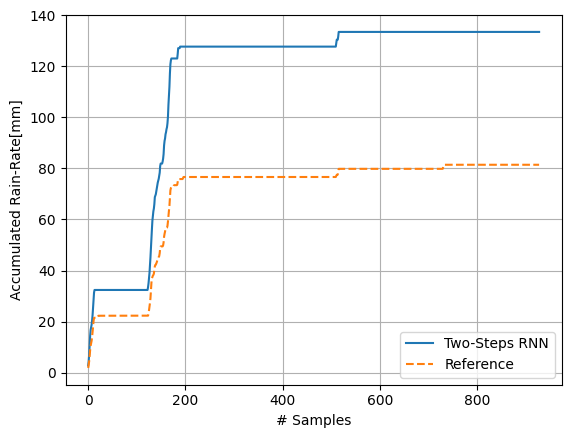

In [26]:
rain_hat_array = np.concatenate(rain_hat_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)

plt.plot(np.cumsum(np.maximum(rain_hat_array[0, :], 0)), label="Two-Steps RNN")
plt.plot(np.cumsum(rain_ref_array[0, :]), "--", label="Reference")
plt.grid()
plt.legend()
plt.ylabel("Accumulated Rain-Rate[mm]")
plt.xlabel("# Samples")
plt.show()

# Train transfer models - RNN is frozen

## Create Models

In [27]:
masked_model = pnc.scm.rain_estimation.two_step_network(
            n_layers=n_layers,  # Number of RNN layers
            rnn_type=rnn_type,  # Type of RNN (GRU, LSTM)
            normalization_cfg=pnc.training_helpers.compute_data_normalization(data_loader),  # Compute the normalization statistics from the training dataset.
            rnn_input_size=rnn_input_size,  # 180,  # 90 + 90 (RSL + TSL)
            rnn_n_features=rnn_n_features,  # Number of features in the RNN
            metadata_input_size=len(dataset[0][-1]),  # Number of metadata features
            metadata_n_features=metadata_n_features,
            metadata_n_hidden=metadata_n_hidden,  # Number of hidden layers in the metadata block
            metadata_feature_mask=metadata_feature_mask,
            freeze_rnn=True,
            model_file_path=model_path,
            pretrained=True
        ).to(device)

geo_model = pnc.scm.rain_estimation.two_step_network(
            n_layers=n_layers,  # Number of RNN layers
            rnn_type=rnn_type,  # Type of RNN (GRU, LSTM)
            normalization_cfg=pnc.training_helpers.compute_data_normalization(data_loader),  # Compute the normalization statistics from the training dataset.
            rnn_input_size=rnn_input_size,  # 180,  # 90 + 90 (RSL + TSL)
            rnn_n_features=rnn_n_features,  # Number of features in the RNN
            metadata_input_size=len(dataset[0][-1]),  # Number of metadata features
            metadata_n_features=metadata_n_features,
            metadata_n_hidden=metadata_n_hidden,  # Number of hidden layers in the metadata block
            metadata_feature_mask=None,
            freeze_rnn=True,
            model_file_path=model_path,
            pretrained=True
        ).to(device)

## Train and evaluate masked reference model - no geo features

In [28]:
opt = torch.optim.RAdam(masked_model.parameters(), lr=lr, weight_decay=weight_decay)
ra = pnc.metrics.ResultsAccumulator()
am = pnc.metrics.AverageMetric()

masked_model.train()
print("Start Training")
for epoch in tqdm(range(transfer_epochs)):

    am.clear()
    for rain_rate, rsl, tsl, metadata in data_loader:
        if to_abs_metadata:
            metadata = torch.abs(metadata)
        state = masked_model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            opt.zero_grad()  # Zero gradients
            # Perform sliding window in the CML time series.
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            # Forward pass of the model
            rain_estimation_detection, state = masked_model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                           state.detach())
            rain_hat = rain_estimation_detection[:, :, 0]
            rain_detection = rain_estimation_detection[:, :, 1]
            # Compute loss function
            loss_est = loss_function_rain_est(rain_hat, _rr)
            loss_detection = loss_function_wet_dry(rain_detection, (_rr > 0.1).float())
            loss = lambda_value * loss_est + loss_detection
            # Take the derivative w.r.t. model parameters $\Theta$
            loss.backward()
            opt.step()

            am.add_results(loss=loss.item(), loss_est=loss_est.item(),
                        loss_detection=loss_detection.item())  # Log results to average.
    ra.add_results(loss=am.get_results("loss"), loss_est=am.get_results("loss_est"),
                loss_detection=am.get_results("loss_detection"))
# save model
masked_model_path = f"{results_path}/masked_model_{experiment_name}.pth"
torch.save(masked_model.state_dict(), masked_model_path)
print(f"Masked model saved to {masked_model_path}")


Start Training


100%|██████████| 200/200 [02:52<00:00,  1.16it/s]

Masked model saved to results_files/masked_model_exp_31.pth


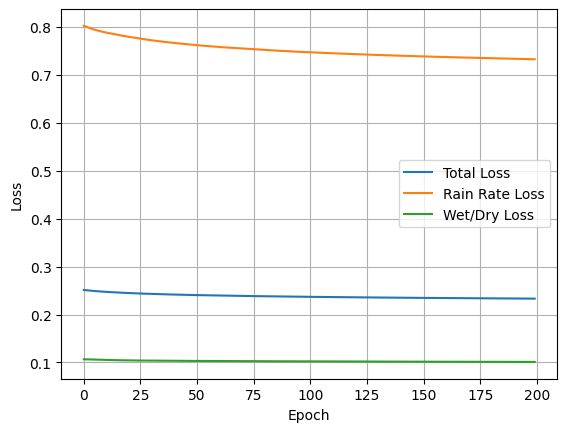

In [29]:
plt.plot(ra.get_results("loss"), label="Total Loss")
plt.plot(ra.get_results("loss_est"), label="Rain Rate Loss")
plt.plot(ra.get_results("loss_detection"), label="Wet/Dry Loss")
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Results Detection:
Validation Results of Masked Reference Model
Accuracy[%]: 96.51939655172413
F1 Score: 0.7733333333333333
Precision: 0.7916666666666666
Recall: 0.7558299039780522


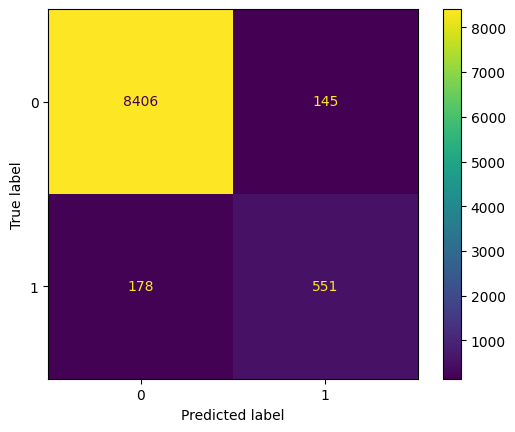

Results Estimation:
-------------------------------------------------- Results Summery --------------------------------------------------
+--------------+-------------------------+----------------------------------------+----------------------------------------+---------------------------------------+---------------------------------------+
|    Metric    | 0.0<r<1.590000033378601 | 1.590000033378601<r<3.1700000762939453 | 3.1700000762939453<r<4.760000228881836 | 4.760000228881836<r<6.349999904632568 | 6.349999904632568<r<7.929999828338623 |
+--------------+-------------------------+----------------------------------------+----------------------------------------+---------------------------------------+---------------------------------------+
|     RMSE     |           0.25          |                  1.0                   |                  1.53                  |                  2.96                 |                  3.88                 |
|     BIAS     |          -0.02          |

In [30]:
masked_model.eval()
# ga = pnc.analysis.GroupAnalysis()
ga = pnc.metrics.GroupAnalysis()
with torch.no_grad():
    for rain_rate, rsl, tsl, metadata in val_loader:
        if to_abs_metadata:
            metadata = torch.abs(metadata)
        state = masked_model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        # am.clear()
        rain_ref_list = []
        rain_hat_list = []
        detection_list = []

        for step in range(m_step):
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = masked_model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                           state.detach())
            rain_detection = rain_estimation_detection[:, :, 1]
            rain_hat = rain_estimation_detection[:, :, 0] * torch.round(
                rain_detection)  # Rain Rate is computed only for wet samples
            rain_hat_list.append(rain_hat.detach().cpu().numpy())
            rain_ref_list.append(_rr.detach().cpu().numpy())
            ga.append(rain_ref_list[-1], rain_hat_list[-1])
            detection_list.append(torch.round(rain_detection).detach().cpu().numpy())
            delta = rain_hat.squeeze(dim=-1) - _rr
            bias = torch.mean(delta)
            mse = torch.mean(delta ** 2)
            am.add_results(bias=bias.item(), mse=mse.item())
# actual = np.concatenate(detection_list).flatten()
# predicted = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
predicted = np.concatenate(detection_list).flatten()
actual = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
confusion_matrix = metrics.confusion_matrix(actual, predicted)
max_rain = np.max(np.concatenate(rain_ref_list))
g_array = np.linspace(0, max_rain, 6)

print("Results Detection:")
print("Validation Results of Masked Reference Model")
print("Accuracy[%]:", 100 * (np.sum(actual == predicted) / actual.size))
print("F1 Score:", metrics.f1_score(actual, predicted))
print("Precision:", metrics.precision_score(actual, predicted))
print("Recall:", metrics.recall_score(actual, predicted))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

cm_display.plot()
plt.show()

print("Results Estimation:")
_, _, _, nrmse, nbias = ga.run_analysis(np.stack([g_array[:-1], g_array[1:]], axis=-1))


In [31]:

masked_results_dict = {
    "loss": ra.get_results("loss"),
    "loss_est": ra.get_results("loss_est"),
    "loss_detection": ra.get_results("loss_detection"),
    "accuracy": 100 * (np.sum(actual == predicted) / actual.size),
    "f1_score": metrics.f1_score(actual, predicted),
    "precision": metrics.precision_score(actual, predicted),
    "recall": metrics.recall_score(actual, predicted),
    "confusion_matrix": confusion_matrix,
    "nbias": nbias,
    "nrmse": nrmse
}

# save results dict
with open(f"{results_path}/masked_results_{experiment_name}.pkl", "wb") as f:
    pickle.dump(masked_results_dict, f)

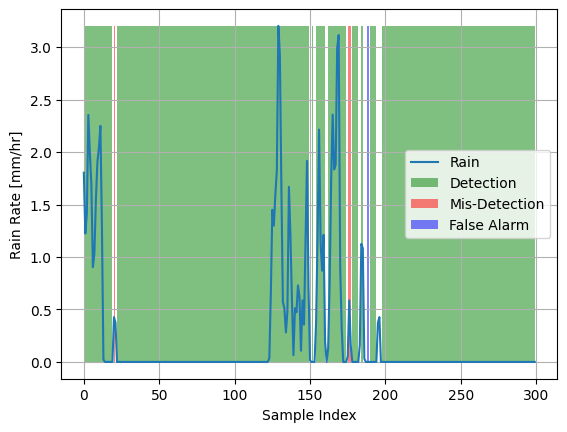

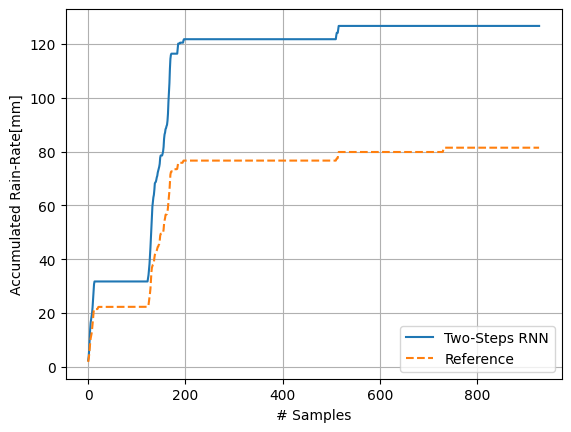

In [32]:
detection_array = np.concatenate(detection_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)
detection_array = np.round(detection_array)

rain_array = rain_ref_array[0, :300]
detection_array = detection_array[0, :300]
fig, ax = plt.subplots()
x = np.arange(rain_array.shape[0])
ax.plot(x, rain_array, label="Rain")
rain_max = np.max(rain_array)
ax.fill_between(x, rain_max, where=np.logical_or(np.logical_and(detection_array == 1, rain_array > 0),
                                                 np.logical_and(detection_array == 0, rain_array == 0)),
                                                 facecolor='green', alpha=.5, label="Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 0, rain_array > 0), facecolor='red',
                alpha=.5, label="Mis-Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 1, rain_array == 0), facecolor='blue',
                alpha=.5, label="False Alarm")
plt.legend()
plt.ylabel("Rain Rate [mm/hr]")
plt.xlabel("Sample Index")
plt.grid()
plt.show()


rain_hat_array = np.concatenate(rain_hat_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)

plt.plot(np.cumsum(np.maximum(rain_hat_array[0, :], 0)), label="Two-Steps RNN")
plt.plot(np.cumsum(rain_ref_array[0, :]), "--", label="Reference")
plt.grid()
plt.legend()
plt.ylabel("Accumulated Rain-Rate[mm]")
plt.xlabel("# Samples")
plt.show()

## Train and evaluate geo_features model

In [33]:
opt = torch.optim.RAdam(geo_model.parameters(), lr=lr, weight_decay=weight_decay)
ra = pnc.metrics.ResultsAccumulator()
am = pnc.metrics.AverageMetric()

geo_model.train()
print("Start Training")
for epoch in tqdm(range(transfer_epochs)):

    am.clear()
    for rain_rate, rsl, tsl, metadata in data_loader:
        if to_abs_metadata:
            metadata = torch.abs(metadata)
        state = geo_model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            opt.zero_grad()  # Zero gradients
            # Perform sliding window in the CML time series.
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            # Forward pass of the model
            rain_estimation_detection, state = geo_model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                           state.detach())
            rain_hat = rain_estimation_detection[:, :, 0]
            rain_detection = rain_estimation_detection[:, :, 1]
            # Compute loss function
            loss_est = loss_function_rain_est(rain_hat, _rr)
            loss_detection = loss_function_wet_dry(rain_detection, (_rr > 0.1).float())
            loss = lambda_value * loss_est + loss_detection
            # Take the derivative w.r.t. model parameters $\Theta$
            loss.backward()
            opt.step()

            am.add_results(loss=loss.item(), loss_est=loss_est.item(),
                        loss_detection=loss_detection.item())  # Log results to average.
    ra.add_results(loss=am.get_results("loss"), loss_est=am.get_results("loss_est"),
                loss_detection=am.get_results("loss_detection"))
# save model
geo_model_path = f"{results_path}/geo_model_{experiment_name}.pth"
torch.save(masked_model.state_dict(), geo_model_path)
print(f"Geo Features model saved to {geo_model_path}")


Start Training


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]

Geo Features model saved to results_files/geo_model_exp_31.pth


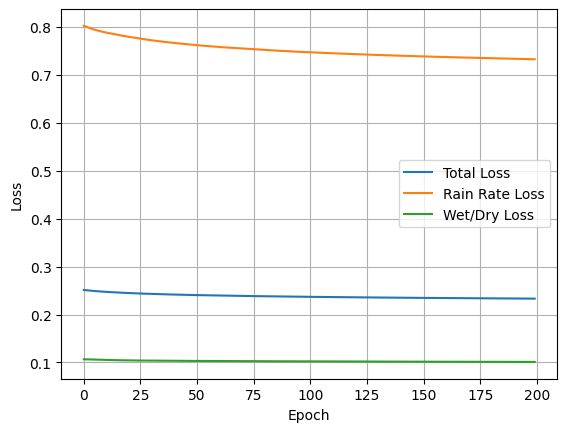

In [34]:
plt.plot(ra.get_results("loss"), label="Total Loss")
plt.plot(ra.get_results("loss_est"), label="Rain Rate Loss")
plt.plot(ra.get_results("loss_detection"), label="Wet/Dry Loss")
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Results Detection:
Validation Results of Geo Features Model
Accuracy[%]: 96.51939655172413
F1 Score: 0.7733333333333333
Precision: 0.7916666666666666
Recall: 0.7558299039780522


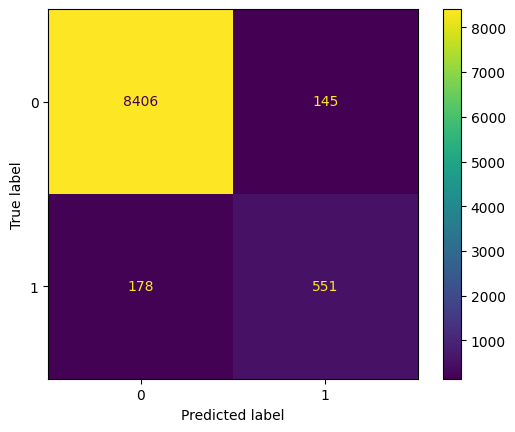

Results Estimation:
-------------------------------------------------- Results Summery --------------------------------------------------
+--------------+-------------------------+----------------------------------------+----------------------------------------+---------------------------------------+---------------------------------------+
|    Metric    | 0.0<r<1.590000033378601 | 1.590000033378601<r<3.1700000762939453 | 3.1700000762939453<r<4.760000228881836 | 4.760000228881836<r<6.349999904632568 | 6.349999904632568<r<7.929999828338623 |
+--------------+-------------------------+----------------------------------------+----------------------------------------+---------------------------------------+---------------------------------------+
|     RMSE     |           0.25          |                  1.0                   |                  1.53                  |                  2.96                 |                  3.88                 |
|     BIAS     |          -0.02          |

In [35]:
geo_model.eval()
# ga = pnc.analysis.GroupAnalysis()
ga = pnc.metrics.GroupAnalysis()
with torch.no_grad():
    for rain_rate, rsl, tsl, metadata in val_loader:
        if to_abs_metadata:
            metadata = torch.abs(metadata)
        state = geo_model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        # am.clear()
        rain_ref_list = []
        rain_hat_list = []
        detection_list = []

        for step in range(m_step):
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = geo_model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                           state.detach())
            rain_detection = rain_estimation_detection[:, :, 1]
            rain_hat = rain_estimation_detection[:, :, 0] * torch.round(
                rain_detection)  # Rain Rate is computed only for wet samples
            rain_hat_list.append(rain_hat.detach().cpu().numpy())
            rain_ref_list.append(_rr.detach().cpu().numpy())
            ga.append(rain_ref_list[-1], rain_hat_list[-1])
            detection_list.append(torch.round(rain_detection).detach().cpu().numpy())
            delta = rain_hat.squeeze(dim=-1) - _rr
            bias = torch.mean(delta)
            mse = torch.mean(delta ** 2)
            am.add_results(bias=bias.item(), mse=mse.item())
# actual = np.concatenate(detection_list).flatten()
# predicted = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
predicted = np.concatenate(detection_list).flatten()
actual = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
confusion_matrix = metrics.confusion_matrix(actual, predicted)
max_rain = np.max(np.concatenate(rain_ref_list))
g_array = np.linspace(0, max_rain, 6)

print("Results Detection:")
print("Validation Results of Geo Features Model")
print("Accuracy[%]:", 100 * (np.sum(actual == predicted) / actual.size))
print("F1 Score:", metrics.f1_score(actual, predicted))
print("Precision:", metrics.precision_score(actual, predicted))
print("Recall:", metrics.recall_score(actual, predicted))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

cm_display.plot()
plt.show()

print("Results Estimation:")
_, _, _, nrmse, nbias = ga.run_analysis(np.stack([g_array[:-1], g_array[1:]], axis=-1))


In [36]:

geo_results_dict = {
    "loss": ra.get_results("loss"),
    "loss_est": ra.get_results("loss_est"),
    "loss_detection": ra.get_results("loss_detection"),
    "accuracy": 100 * (np.sum(actual == predicted) / actual.size),
    "f1_score": metrics.f1_score(actual, predicted),
    "precision": metrics.precision_score(actual, predicted),
    "recall": metrics.recall_score(actual, predicted),
    "confusion_matrix": confusion_matrix,
    "nbias": nbias,
    "nrmse": nrmse
}

# save results dict
with open(f"{results_path}/geo_results_{experiment_name}.pkl", "wb") as f:
    pickle.dump(geo_results_dict, f)

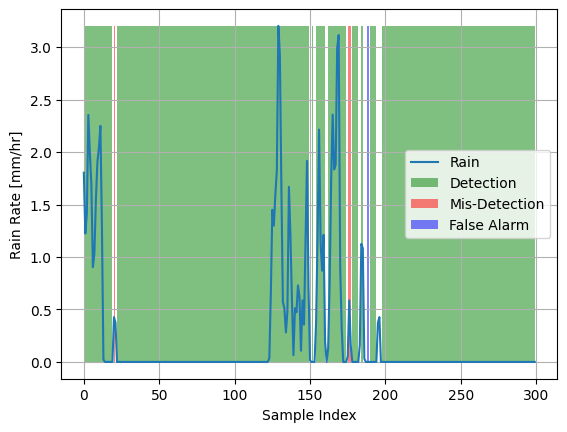

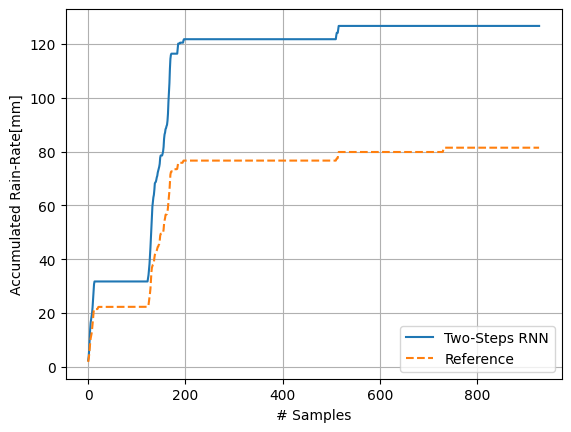

In [37]:
detection_array = np.concatenate(detection_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)
detection_array = np.round(detection_array)

rain_array = rain_ref_array[0, :300]
detection_array = detection_array[0, :300]
fig, ax = plt.subplots()
x = np.arange(rain_array.shape[0])
ax.plot(x, rain_array, label="Rain")
rain_max = np.max(rain_array)
ax.fill_between(x, rain_max, where=np.logical_or(np.logical_and(detection_array == 1, rain_array > 0),
                                                 np.logical_and(detection_array == 0, rain_array == 0)),
                                                 facecolor='green', alpha=.5, label="Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 0, rain_array > 0), facecolor='red',
                alpha=.5, label="Mis-Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 1, rain_array == 0), facecolor='blue',
                alpha=.5, label="False Alarm")
plt.legend()
plt.ylabel("Rain Rate [mm/hr]")
plt.xlabel("Sample Index")
plt.grid()
plt.show()


rain_hat_array = np.concatenate(rain_hat_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)

plt.plot(np.cumsum(np.maximum(rain_hat_array[0, :], 0)), label="Two-Steps RNN")
plt.plot(np.cumsum(rain_ref_array[0, :]), "--", label="Reference")
plt.grid()
plt.legend()
plt.ylabel("Accumulated Rain-Rate[mm]")
plt.xlabel("# Samples")
plt.show()

# References

[1] Habi, Hai Victor, and Hagit Messer. "Recurrent neural network for rain estimation using commercial microwave links." IEEE Transactions on Geoscience and Remote Sensing 59.5 (2020): 3672-3681.

[2] van de Beek, Remco CZ, et al. OpenMRG: Open data from Microwave links, Radar, and Gauges for rainfall quantification in Gothenburg, Sweden. No. EGU23-14295. Copernicus Meetings, 2023.
